In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
epochs = 1
model_name = 'BiLSTM'

In [3]:
import pandas as pd
import numpy as np
import json

In [4]:
data_path = '/home/Danny/Data-Mining/lab2/kaggle/data/'

In [5]:
json_list = list()
with open(data_path + 'tweets_DM.json' , 'r') as file:
    for line in file:
        json_list.append(json.loads(line))

In [6]:
tweet_list = list()
for json in json_list:
    tweet_id = json['_source']['tweet']['tweet_id']
    hashtags = json['_source']['tweet']['hashtags']
    hashtag = ' '.join(hashtags)
    text = json['_source']['tweet']['text']
    text = text + ' ' + hashtag
    tweet_list.append([tweet_id, text])

In [7]:
text_df = pd.DataFrame(tweet_list, columns=['tweet_id', 'text'])

In [8]:
emotion_df = pd.read_csv(data_path + 'emotion.csv')
# emotion_df

In [9]:
identification_df = pd.read_csv(data_path + 'data_identification.csv')
# identification_df

In [10]:
test_df = identification_df[identification_df['identification'] == 'test']
# test_df

In [11]:
train_df = text_df.merge(emotion_df, left_on='tweet_id', right_on='tweet_id')
# train_df

In [12]:
x_list = train_df['text'].to_list()
y_list = train_df['emotion'].to_list()

In [13]:
x_list_list = list()
for x in x_list:
    x_list_list.append(x.split())
len(x_list_list)

1455563

In [14]:
x_list_list

[['People',
  'who',
  'post',
  '"add',
  'me',
  'on',
  '#Snapchat"',
  'must',
  'be',
  'dehydrated.',
  'Cuz',
  'man....',
  "that's",
  '<LH>',
  'Snapchat'],
 ['@brianklaas',
  'As',
  'we',
  'see,',
  'Trump',
  'is',
  'dangerous',
  'to',
  '#freepress',
  'around',
  'the',
  'world.',
  'What',
  'a',
  '<LH>',
  '<LH>',
  '#TrumpLegacy.',
  '#CNN',
  'freepress',
  'TrumpLegacy',
  'CNN'],
 ['Now', 'ISSA', 'is', 'stalking', 'Tasha', '😂😂😂', '<LH>'],
 ['@RISKshow',
  '@TheKevinAllison',
  'Thx',
  'for',
  'the',
  'BEST',
  'TIME',
  'tonight.',
  'What',
  'stories!',
  'Heartbreakingly',
  '<LH>',
  '#authentic',
  '#LaughOutLoud',
  'good!!',
  'authentic',
  'LaughOutLoud'],
 ['Still', 'waiting', 'on', 'those', 'supplies', 'Liscus.', '<LH>'],
 ['Love', 'knows', 'no', 'gender.', '😢😭', '<LH>'],
 ['@DStvNgCare',
  '@DStvNg',
  'More',
  'highlights',
  'are',
  'being',
  'shown',
  'than',
  'actual',
  'sports!',
  'Who',
  'watches',
  'triathlon',
  'highlights',
  

In [15]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x_list_list, y_list, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))
print(len(valid_x), len(valid_y))

931560 931560
291113 291113
232890 232890


In [16]:
import kashgari
from kashgari.tasks.classification import BiLSTM_Model
kashgari.config.use_cudnn_cell = True
import logging
logging.basicConfig(level='DEBUG')
# from kashgari.embeddings import BertEmbedding
# bert_embed = BertEmbedding('/home/Danny/pretrain_model/bert_tiny')
# model = BiLSTM_Model(bert_embed, sequence_length=128)
model = BiLSTM_Model()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(train_x, 
                    train_y, 
                    valid_x, 
                    valid_y,
                    epochs=epochs,
         )

Preparing text vocab dict: 100%|██████████| 232890/232890 [00:01<00:00, 183625.64it/s]
2020-11-30 22:19:25,446 [DEBUG] kashgari - --- Build vocab dict finished, Total: 257059 ---
2020-11-30 22:19:25,446 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '<LH>', 'the', 'to', 'I', 'a', 'and']
Calculating sequence length: 100%|██████████| 232890/232890 [00:00<00:00, 1961768.18it/s]
2020-11-30 22:19:27,419 [DEBUG] kashgari - Calculated sequence length = 27
2020-11-30 22:19:28,692 [DEBUG] kashgari - Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_embedding (Embedding)  (None, None, 100)         25705900  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
________

14555/14555 [==============================] - 2320s 159ms/step - loss: 1.2262 - accuracy: 0.5566 - val_loss: 1.1334 - val_accuracy: 0.5913


In [17]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
model.save(model_path)

2020-11-30 22:58:13,537 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 49
2020-11-30 22:58:16,082 [DEBUG] kashgari - predict input shape (291113, 49) x: 
[[   2  935    8 ...    0    0    0]
 [   2  788   61 ...    0    0    0]
 [   2 3465   80 ...    0    0    0]
 ...
 [   2    7 1600 ...    0    0    0]
 [   2    4    9 ...    0    0    0]
 [   2 2281 6163 ...    0    0    0]]
2020-11-30 22:59:15,038 [DEBUG] kashgari - predict output shape (291113, 8)
2020-11-30 22:59:15,178 [DEBUG] kashgari - predict output argmax: [0 1 0 ... 0 0 5]


              precision    recall  f1-score   support

       anger     0.6288    0.2420    0.3495      7946
anticipation     0.6787    0.5932    0.6331     49984
     disgust     0.5171    0.3897    0.4445     27669
        fear     0.7007    0.4246    0.5287     12846
         joy     0.5813    0.8465    0.6892    102943
     sadness     0.5015    0.5523    0.5257     38745
    surprise     0.6829    0.2370    0.3518      9816
       trust     0.6937    0.3327    0.4497     41164

    accuracy                         0.5921    291113
   macro avg     0.6231    0.4522    0.4965    291113
weighted avg     0.6072    0.5921    0.5730    291113



2020-11-30 22:59:22,146 [INFO] kashgari - model saved to /home/Danny/Data-Mining/lab2/kaggle/kashgari/model/BiLSTM_epoch_1


'/home/Danny/Data-Mining/lab2/kaggle/kashgari/model/BiLSTM_epoch_1'

In [18]:
from matplotlib import pyplot as plt

DEBUG:matplotlib:CONFIGDIR=/home/Danny/.config/matplotlib
DEBUG:matplotlib:(private) matplotlib data path: /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.2.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconf

DEBUG:matplotlib:CACHEDIR=/home/Danny/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/Danny/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sco

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manag

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-RI.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gargi' (Gargi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Vemana2000' (vemana2000.ttf) normal norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sawasdee' (Sawasdee-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstLetter' (KacstLetter.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Purisa' (Purisa-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'N

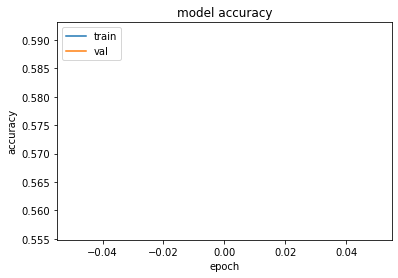

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

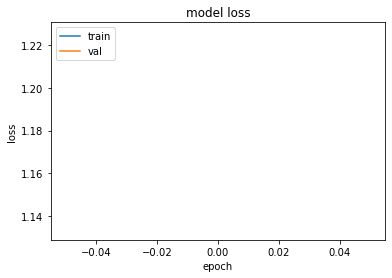

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
# model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
# model = kashgari.utils.load_model(model_path)
# model.evaluate(test_x, test_y)

In [22]:
test_df = test_df.merge(text_df, left_on='tweet_id', right_on='tweet_id')
test_df

,tweet_id,identification,text
0,0x28cc61,test,@Habbo I've seen two separate colours of the e...
1,0x2db41f,test,@FoxNews @KellyannePolls No serious self respe...
2,0x2466f6,test,"Looking for a new car, and it says 1 lady owne..."
3,0x23f9e9,test,@cineworld “only the brave” just out and fount...
4,0x1fb4e1,test,Felt like total dog 💩 going into open gym and ...
...,...,...,...
411967,0x2c4dc2,test,6 year old walks in astounded. Mum! Look how b...
411968,0x31be7c,test,Only one week to go until the #inspiringvolunt...
411969,0x1ca58e,test,"I just got caught up with the manga for ""My He..."
411970,0x35c8ba,test,Speak only when spoken to and make hot ass mus...


In [23]:
text_list = list()
for text in test_df['text'].tolist():
    text_list.append(text.split())
text_list

[['@Habbo',
  "I've",
  'seen',
  'two',
  'separate',
  'colours',
  'of',
  'the',
  'elegant',
  'furni',
  'on',
  'your',
  'homepage?',
  '<LH>'],
 ['@FoxNews',
  '@KellyannePolls',
  'No',
  'serious',
  'self',
  'respecting',
  'individual',
  'believes',
  'much',
  'less',
  'agrees',
  'w',
  'her',
  '<LH>'],
 ['Looking',
  'for',
  'a',
  'new',
  'car,',
  'and',
  'it',
  'says',
  '1',
  'lady',
  'owner.',
  'That',
  'means',
  'needs',
  'new',
  'clutch,',
  'gearbox',
  'and',
  'brakes.',
  '#womendrivers',
  '<LH>',
  'womendrivers'],
 ['@cineworld',
  '“only',
  'the',
  'brave”',
  'just',
  'out',
  'and',
  'fountain',
  'park',
  'have',
  'only',
  '3',
  'showings',
  'per',
  'day!',
  '<LH>',
  '#robbingmembers',
  'robbingmembers'],
 ['Felt',
  'like',
  'total',
  'dog',
  '💩',
  'going',
  'into',
  'open',
  'gym',
  'and',
  'had',
  'a',
  'migraine',
  'Played',
  'through',
  'and',
  'sweated',
  'it',
  'out',
  'and',
  'my',
  'sweat',
  'ha

In [ ]:
predict_list = model.predict(text_list)
predict_list

2020-11-30 22:59:31,236 [DEBUG] kashgari - predict input shape (411972, 63) x: 
[[   2    1  187 ...    0    0    0]
 [   2  766 4411 ...    0    0    0]
 [   2  652   10 ...    0    0    0]
 ...
 [   2    7   32 ...    0    0    0]
 [   2 4451   59 ...    0    0    0]
 [   2 1811   47 ...    0    0    0]]


In [ ]:
test_df['predict'] = predict_list
test_df

In [ ]:
output_df = test_df[['tweet_id', 'predict']]
output_df = output_df.rename(columns={'tweet_id':'id', 'predict':'emotion'})
# output_df

In [ ]:
output_path = 'output/{}_epoch_{}.csv'.format(model_name, epochs)
output_df.to_csv(output_path, index=False, header=True)